In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('iris.csv')

seperating features and label

In [3]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

In [4]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [5]:
# Split into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0, stratify=y
)

In [6]:
print("Data loaded and split successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data loaded and split successfully.
Training set shape: (105, 4)
Test set shape: (45, 4)


In [7]:
def calculate_covariance_matrix(data):
    """    
    Formula: Sigma = (X_centered.T @ X_centered) / (n - 1)
    """
    n = data.shape[0]
    # Mean centering
    mean_vec = np.mean(data, axis=0)
    data_centered = data - mean_vec
    
    # Covariance matrix calculation
    cov_mat = (data_centered.T @ data_centered) / (n - 1)
    return cov_mat

In [8]:
cov_mat = calculate_covariance_matrix(X_train)
print("\nCovariance Matrix:\n", cov_mat)


Covariance Matrix:
 [[ 1.08930066 -0.08208861  0.93739004  0.85918638]
 [-0.08208861  1.09729262 -0.4360605  -0.37539208]
 [ 0.93739004 -0.4360605   1.0539395   0.99645508]
 [ 0.85918638 -0.37539208  0.99645508  1.01579566]]


In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print("\nEigenvalues:\n", eigen_vals)
print("\nEigenvectors:\n", eigen_vecs)


Eigenvalues:
 [3.05498439 1.03644594 0.14478637 0.02011174]

Eigenvectors:
 [[ 0.53215061 -0.38222815 -0.70106142  0.2814787 ]
 [-0.25891543 -0.92282753  0.25662295 -0.12448618]
 [ 0.58294421 -0.01899152  0.13097667 -0.80166108]
 [ 0.55673565 -0.04393529  0.65230565  0.51245726]]


In [10]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

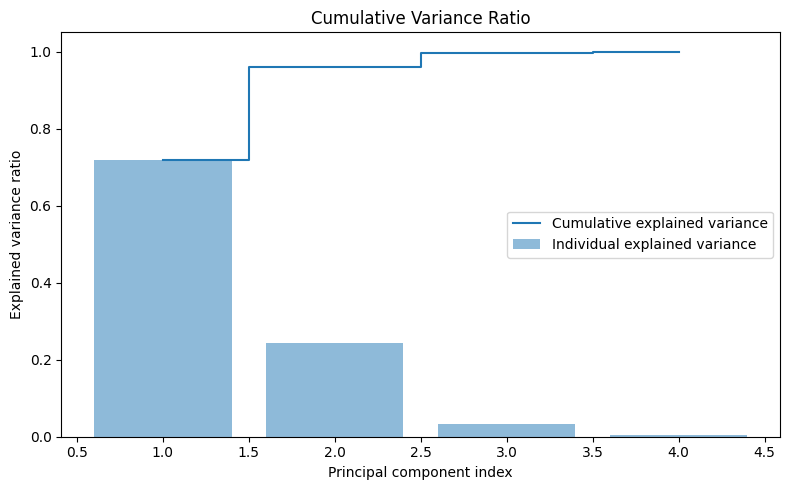

In [11]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, 5), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 5), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Cumulative Variance Ratio')
plt.tight_layout()
plt.show()

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [13]:
# Sort the tuples from high to low based on eigenvalues
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Select top k=3 eigenvectors
w_list = [eigen_pairs[i][1][:, np.newaxis] for i in range(3)]
W = np.hstack(w_list)

print("\nTransformation Matrix W (4x3):\n", W)


Transformation Matrix W (4x3):
 [[ 0.53215061 -0.38222815 -0.70106142]
 [-0.25891543 -0.92282753  0.25662295]
 [ 0.58294421 -0.01899152  0.13097667]
 [ 0.55673565 -0.04393529  0.65230565]]


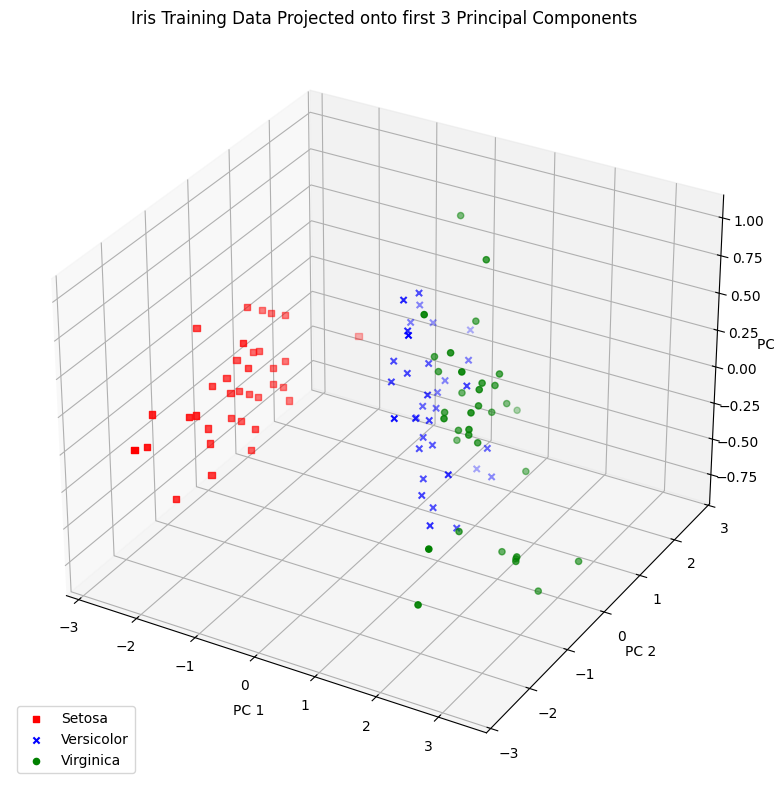

In [16]:
# X_proj = X_std . W
X_train_proj = X_train.dot(W)

# Visualization in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors and markers for the classes
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
classes = np.unique(y_train)

# Plot each class
for l, c, m in zip(classes, colors, markers):
    ax.scatter(X_train_proj[y_train == l, 0], 
               X_train_proj[y_train == l, 1], 
               X_train_proj[y_train == l, 2], 
               c=c, label=l, marker=m)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(loc='lower left')
plt.title('Iris Training Data Projected onto first 3 Principal Components')
plt.tight_layout()
plt.show()


Within-class Scatter Matrix S_W:
 [[43.1699 29.1978 13.9855  6.5457]
 [29.1978 68.6546  8.0305  9.6601]
 [13.9855  8.0305  7.3325  3.6252]
 [ 6.5457  9.6601  3.6252  7.1635]]

Between-class Scatter Matrix S_B:
 [[ 70.1173 -37.735   83.5031  82.8097]
 [-37.735   45.4639 -53.3807 -48.7008]
 [ 83.5031 -53.3807 102.2772 100.0062]
 [ 82.8097 -48.7008 100.0062  98.4793]]

Eigenvalues in descending order:
28.9944
0.3370
0.0000
0.0000


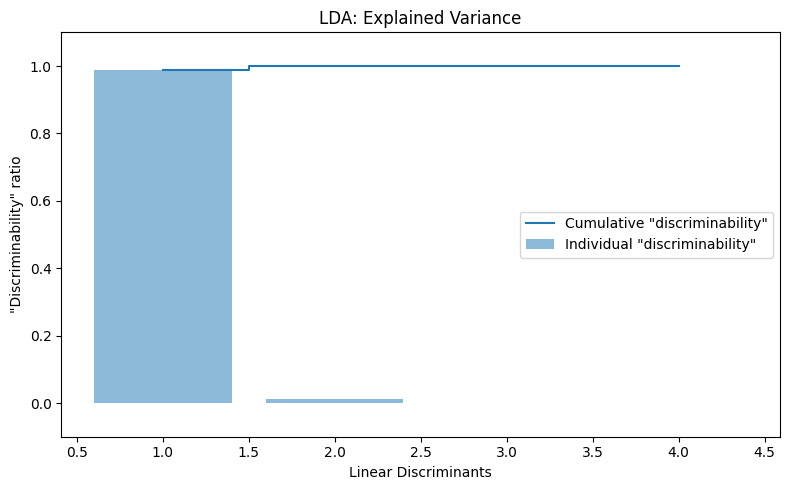


Transformation Matrix W (4x2):
 [[-0.1738 -0.167 ]
 [-0.1309 -0.2019]
 [ 0.8224  0.6881]
 [ 0.5257 -0.6767]]


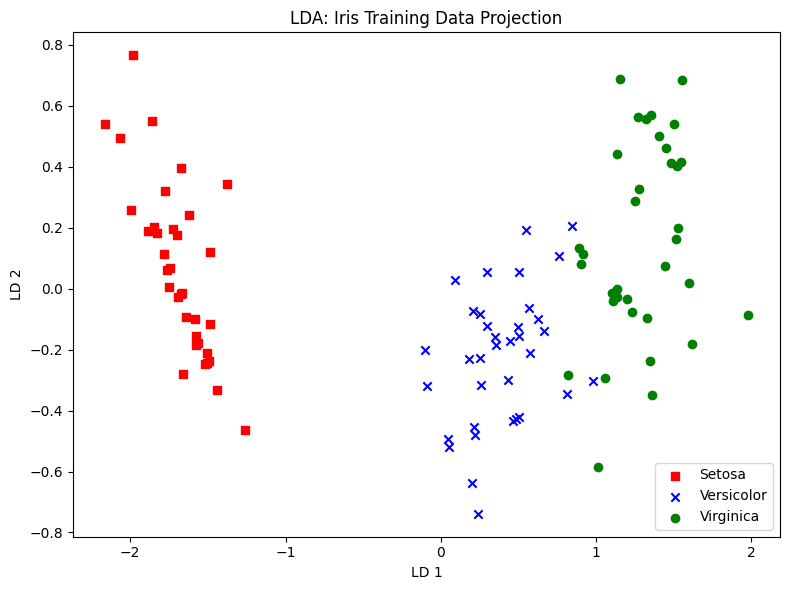

In [17]:
# --- 2. Compute Mean Vectors ---
np.set_printoptions(precision=4)
mean_vecs = []
classes = np.unique(y_train)
for label in classes:
    mean_vecs.append(np.mean(X_train[y_train == label], axis=0))

# --- 3. Compute Within-class Scatter Matrix (S_W) ---
d = X_train.shape[1] # number of features (4)
S_W = np.zeros((d, d))

for label, mv in zip(classes, mean_vecs):
    class_scatter = np.zeros((d, d))
    # Add scatter for each sample in the class
    for row in X_train[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print("\nWithin-class Scatter Matrix S_W:\n", S_W)

# --- 4. Compute Between-class Scatter Matrix (S_B) ---
mean_overall = np.mean(X_train, axis=0).reshape(d, 1) # Mean of all samples
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == classes[i]].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    # Weighted difference between class mean and overall mean
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print("\nBetween-class Scatter Matrix S_B:\n", S_B)

# --- 5. Eigendecomposition of S_W^-1 S_B ---
# We compute eigenvalues of inv(S_W).dot(S_B)
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Sort eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print("\nEigenvalues in descending order:")
for i in eigen_pairs:
    print(f"{i[0]:.4f}")

# --- 6. Plot Explained Variance (Discriminability) ---
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.figure(figsize=(8, 5))
plt.bar(range(1, 5), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, 5), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.title('LDA: Explained Variance')
plt.tight_layout()
plt.show()

# --- 7. Project Data onto new subspace ---
# Select top k=2 eigenvectors (since there are only c-1 = 2 non-zero eigenvalues)
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
               eigen_pairs[1][1][:, np.newaxis].real))

print("\nTransformation Matrix W (4x2):\n", W)

X_train_lda = X_train.dot(W)

# --- 8. Plot Projected Data ---
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

plt.figure(figsize=(8, 6))
for l, c, m in zip(classes, colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], 
                X_train_lda[y_train == l, 1] * (-1), 
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.title('LDA: Iris Training Data Projection')
plt.tight_layout()
plt.show()